# Ingredient Exploration

Let's check out the distribution of values for different columns. Note that this notebook requires *a lot* of memory (8+ GB).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
store = pd.HDFStore("all_recipes.h5","r")

In [3]:
keys = store.keys()
keys

['/core', '/ingredients']

In [4]:
core = store.get("core")

In [6]:
core.head()

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,
0,20.819765,24.983718,60.0,pope,0.75,boo,recipes/boo.xml,20a,bjcp,fruit beer,1.0
1,18.927059,23.658824,60.0,casey witherow,0.80,pumpkin ale 2012,recipes/pumpkin-ale-2012-3.xml,23a,bjcp,specialty beer,1.0
2,22.712471,28.390588,60.0,leonardgrimes,0.75,hoppy ale 19 legacy,recipes/hoppy-ale-19-legacy.xml,23a,bjcp,specialty beer,1.0
3,20.819765,26.043633,60.0,beefcake,0.80,cherry wheat,recipes/cherry-wheat-10.xml,23a,bjcp,specialty beer,1.0
4,20.819765,24.983718,60.0,dukeredhair,0.75,bright and bitter (just like my men) 4,recipes/bright-and-bitter-just-like-my-men-4.xml,14b,bjcp,american ipa,1.0


Let's start by looking at batch_size, boil_size, boil_time, and efficiency

In [7]:
cols = ["batch_size", "boil_size", "boil_time", "efficiency"]

In [11]:
core[cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

,batch_size,boil_size,boil_time,efficiency
count,330790.000000,330790.000000,330790.000000,330786.000000
mean,32.982284,33.567950,64.158034,0.731820
std,185.620543,182.689716,174.567092,0.068315
min,0.200000,-227.011144,0.000000,0.000000
1%,3.785412,3.320000,30.000000,0.375000
5%,9.463529,6.336000,60.000000,0.620000
25%,18.927059,22.712471,60.000000,0.750000
50%,19.684141,23.658824,60.000000,0.750000
75%,21.955388,27.027840,60.000000,0.750000
95%,45.424941,54.093534,90.000000,0.800000


Let's start by looking at these crazy maxima...

In [13]:
core.iloc[core["batch_size"].argmax()]

/home/rory/Preteckt/utils/gm-repo/preteckt_gm/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


batch_size                        28000
boil_size                       8876.18
boil_time                            60
brewer                      sam corbeil
efficiency                         0.95
name                            project
recipe_file       recipes/project-1.xml
style_category                       2a
style_guide                        bjcp
style_name        german pilsner (pils)
style_version                         1
Name: 135918, dtype: object

Some interesting notes from Rob...

  * Sam Corbeil is [the brewmaster at Sawdust City](https://www.sawdustcitybrewing.com/team_member/sam-corbeil/) in Muskoka. It is apparently a well-known "secret" that he posts the brewery's recipes on brewtoad.
  * Boil size is typically the largest volume in your recipe since it is the volume of liquid you start with. Everything you do to your recipe after this decreases the amount of liquid you'll end up with.
      * Boiling will decrease liquid (usually about 10%/hour for home brew, ~5%/hr for commercial)
      * Cooling will decrease ~4%
      * Lose volume to [trub](https://en.wikipedia.org/wiki/Trub_(brewing)) as well (where solids separate from the liquid). This can vary from 2-10%.
      * Wort then goes into fermenter, where fermentation will steal volume, 5-30% (wow!)
      * A little bit of loss in [racking](https://en.wikipedia.org/wiki/Racking), which is transferring from fermenter to secondary fermenter (bright tank in commercial brewing). FYI, "bright" is a breweing term meaning "clear", indicating nothing else needs to happen to the beer before bottling/kegging.
      * Finally, can lose volume in the actual bottling/kegging process. Could be ~10% (higher in home brewing).
      * Note that the above percentages all refer to the volume from the previous step, not the original volume.
  * Batch size and boil size are usually very close for home brews. Batch size is meant to be the final kegged/bottled volume, but sometimes people treat it as the volume in the fermenter.
  * Sometimes, commercial recipes will have multiple boils go into one batch. In this case, batch_size is ~3.2x the boil size, so it's likely that the batch actually includes 4 boils. We should make sure to properly consider this when normalizing quantities.

The takeaway from the above is that the boil size is pretty clear whereas the batch size can vary a lot, and even the interpretation varies since it can be bottled volume vs fermenter volume.

One way to identify problematic recipes might be to look at $\frac{batch\_size}{boil\_size}$

In [16]:
core["vol_ratio"] = core["batch_size"] / core["boil_size"]

In [17]:
core["vol_ratio"].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

count    330790.000000
mean          0.942521
std          26.400761
min       -5000.000000
1%            0.598528
5%            0.700117
25%           0.799679
50%           0.800000
75%           0.833333
95%           3.134796
99%           3.443526
max         874.027778
Name: vol_ratio, dtype: float64

Why are there negative ratios? It looks like there are some negative boil sizes... what's up with those?

In [20]:
core[core["boil_size"] < 0]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version,vol_ratio
id,,,,,,,,,,,,
240,22.712471,-1.135624,60.0,robertmeyer6,0.650,saison 3711,recipes/saison-3711.xml,16c,bjcp,saison,1.0,-20.000000
5973,23.090000,-0.380000,60.0,antonio garofalo,0.750,ascipa 2 3 luppoli,recipes/ascipa-2-3-luppoli-1.xml,14b,bjcp,american ipa,1.0,-60.763158
9326,20.000000,-0.004000,60.0,sjkim/soma,0.700,ipa,recipes/ipa-822.xml,10a,bjcp,american pale ale,1.0,-5000.000000
17270,22.712471,-113.562353,360.0,brian keifer,0.750,tokillya barleywine,recipes/tokillya-barleywine.xml,22c,bjcp,wood-aged beer,1.0,-0.200000
21741,22.712471,-113.562353,360.0,paul,0.740,doomsday imperial porter,recipes/doomsday-imperial-porter.xml,22c,bjcp,wood-aged beer,1.0,-0.200000
31812,18.927059,-4.731765,60.0,cyrock1,0.750,muscat wit,recipes/muscat-wit.xml,23a,bjcp,specialty beer,1.0,-4.000000
38745,18.927059,-1.173478,60.0,sunporch brewery,0.750,brecksville double ipa,recipes/brecksville-double-ipa.xml,14c,bjcp,imperial ipa,1.0,-16.129032
40569,9.501384,-47.317647,360.0,brandon myers,0.700,old longboil,recipes/old-longboil.xml,19b,bjcp,english barleywine,1.0,-0.200800
51941,18.930000,-0.380000,60.0,antonio garofalo,0.720,foreign extra stout,recipes/foreign-extra-stout-17.xml,13d,bjcp,foreign extra stout,1.0,-49.815789


In [26]:
core[core["vol_ratio"] > 1]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version,vol_ratio
id,,,,,,,,,,,,
5,23.000000,7.080000,60.0,cosmo,0.750,#36 fhh,recipes/36-fhh.xml,10a,bjcp,american pale ale,1.0,3.248588
9,3.798000,1.700000,60.0,curleez & me,0.750,3 bean stout clone,recipes/3-bean-stout-clone.xml,13b,bjcp,sweet stout,1.0,2.234118
24,18.927059,17.034353,60.0,justin,0.750,first try belgian red,recipes/first-try-belgian-red-54197d.xml,16e,bjcp,belgian specialty ale,1.0,1.111111
31,22.000000,7.553000,90.0,puttzog,0.700,fyrvaktarens wee heavy,recipes/fyrvaktarens-wee-heavy.xml,9e,bjcp,strong scotch ale,1.0,2.912750
37,11.000000,4.310000,120.0,bryan,0.720,urquell clone,recipes/urquell-clone-8c7bd6.xml,2b,bjcp,bohemian pilsener,1.0,2.552204
58,20.000000,7.128000,60.0,chip craggs,0.750,robust porter,recipes/robust-porter-168.xml,12b,bjcp,robust porter,1.0,2.805836
59,20.000000,6.655000,75.0,radbeer,0.750,smuttymike,recipes/smuttymike.xml,14b,bjcp,american ipa,1.0,3.005259
73,18.927059,13.627482,60.0,ben salzberg,0.750,pat's canterbury bitter,recipes/pat-s-canterbury-bitter.xml,8c,bjcp,extra special/strong bitter (english pale ale),1.0,1.388889
76,12.000000,4.170000,60.0,hans christian løberg,0.700,imperial brown ale,recipes/imperial-brown-ale-e089ac.xml,10c,bjcp,american brown ale,1.0,2.877698


In [27]:
high_ratio = core[core["vol_ratio"] > 1]["vol_ratio"].values

(array([1.319e+03, 2.229e+03, 9.490e+02, 7.800e+02, 1.849e+03, 9.060e+02,
        9.460e+02, 9.970e+02, 1.008e+03, 7.080e+02, 7.520e+02, 5.680e+02,
        1.198e+03, 8.540e+02, 1.755e+03, 7.210e+02, 7.840e+02, 6.230e+02,
        5.890e+02, 4.800e+02, 6.810e+02, 1.081e+03, 6.440e+02, 1.888e+03,
        1.003e+03, 1.512e+03, 9.191e+03, 1.626e+03, 1.572e+03, 7.730e+02,
        1.314e+03, 4.970e+02, 3.970e+02, 3.590e+02, 6.120e+02, 1.600e+01,
        2.600e+01, 2.800e+01, 1.100e+01, 2.000e+01, 2.300e+01, 2.300e+01,
        2.300e+01, 4.000e+01, 1.100e+01, 7.000e+00, 1.700e+01, 1.200e+01,
        1.200e+01, 2.300e+01]),
 array([1.  , 1.08, 1.16, 1.24, 1.32, 1.4 , 1.48, 1.56, 1.64, 1.72, 1.8 ,
        1.88, 1.96, 2.04, 2.12, 2.2 , 2.28, 2.36, 2.44, 2.52, 2.6 , 2.68,
        2.76, 2.84, 2.92, 3.  , 3.08, 3.16, 3.24, 3.32, 3.4 , 3.48, 3.56,
        3.64, 3.72, 3.8 , 3.88, 3.96, 4.04, 4.12, 4.2 , 4.28, 4.36, 4.44,
        4.52, 4.6 , 4.68, 4.76, 4.84, 4.92, 5.  ]),
 <a list of 50 Patch objects

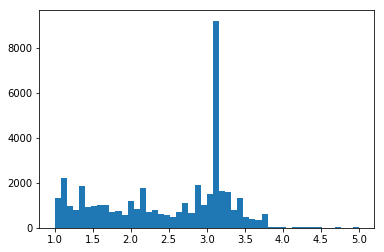

In [29]:
plt.hist(high_ratio, bins=50, range=[1,5])

The above is a bit surprising. The peak near 3 seems reasonable given that breweries will often do 4 boils per batch. However, we would also expect similar peaks for 2, 3, 5, etc.

I guess we should make the assumption that anything near 1 is likely a mixup of boil and batch size, and anything above 2 can maybe be ceiling'd to the integer above for number of boils per batch...

In [34]:
core[(core["brewer"] == "sam corbeil")*(core["batch_size"] > 10000)]

/home/rory/Preteckt/utils/gm-repo/preteckt_gm/env/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version,vol_ratio
id,,,,,,,,,,,,
135918,28000.0,8876.1840,60.0,sam corbeil,0.95,project,recipes/project-1.xml,2a,bjcp,german pilsner (pils),1.0,3.154509
242591,25000.0,6769.4075,60.0,sam corbeil,0.98,golden norway,recipes/golden-norway.xml,10a,bjcp,american pale ale,1.0,3.693085


In [36]:
recipe = store.select("/ingredients", where="index == 135918")
recipe

,amount,attenuation,color,ferm_amount,ferm_display_amount,ferm_name,ferm_origin,ferm_scaled,ferm_yield,flocculation,...,misc_amount,misc_amount_is_weight,misc_name,misc_time,misc_use,potential,product_id,type,yeast_laboratory,yeast_name
id,,,,,,,,,,,,,,,,,,,,,
135918,NaN,77.5,2.0,3800.0,3800.0 kg,canada malting canadian 2-row,NaN,0.307379,0.755776,NaN,...,NaN,False,NaN,NaN,NaN,1.035,NaN,lager,white labs,american lager yeast
135918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Rob thinks the above recipes are actually real. There is a brewery called [Cool Brewery](https://www.coolbeer.com/) that does a lot of contract brewing. They have a large antique copper kettle that other breweries use for contract brewing. It's about 80 HL (hectoliters), which corresponds decently to the boil size in the above recipes. The fact that those are pils and pale ales means they would likely be produced in bigger batches as well. So, long story short, the normalized quanties could be reasonable provided the hop amount is relative to the boil size. More investigation needed...